# The Feature Engineering notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)

Some added featrues:
- is_weekend
- season
- sun_above_threshold
- cos_sun_azimuth 
- sin_sun_azimuth 
- interaction_clear_sky_rad_sun_elevation
- interaction_clear_sky_rad_effective_cloud_cover

## What is new to version 3?
- Extra features

In [771]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [772]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [773]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [774]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [775]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [776]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [777]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [778]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').mean()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').mean()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').mean()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').mean()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').mean()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').mean()


In [779]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [780]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

In [781]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [782]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,...,0.0,278.250000,86.324997,16827.800781,2.800,1.175,2.550,0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,...,0.0,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,...,0.0,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,0,NaT
2019-01-01 01:00:00,0.0,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,...,0.0,278.075012,99.074997,12777.449219,3.550,1.525,3.200,0.0,0,NaT
2019-01-01 02:00:00,0.0,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,...,0.1,278.049988,97.925003,11140.500000,4.025,2.150,3.425,0.0,0,NaT


In [783]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)
    df['sun_above_threshold_9'] = (df['sun_elevation:d'] > -9).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['shadow_sun_elevation_interaction'] = df['is_in_shadow:idx'] * df['sun_elevation:d']

    df['shadow_cos_sun_azimuth_interaction'] = df['is_in_shadow:idx'] * df.get('cos_sun_azimuth', 1) 
    df['shadow_sin_sun_azimuth_interaction'] = df['is_in_shadow:idx'] * df.get('sin_sun_azimuth', 1) 

    df['shadow_clear_sky_rad_interaction'] = df['is_in_shadow:idx'] * df['clear_sky_rad:W']

    df['location_A_shadow_interaction'] = df['location_A'] * df['is_in_shadow:idx']
    df['location_B_shadow_interaction'] = df['location_B'] * df['is_in_shadow:idx']
    df['location_C_shadow_interaction'] = df['location_C'] * df['is_in_shadow:idx']

    df['hour_sun_above_threshold_interaction'] = df['hour'] * df['sun_above_threshold']

    df['dayofyear_sun_above_threshold_interaction'] = df['dayofyear'] * df['sun_above_threshold']

    df['hour_clear_sky_rad_interaction'] = df['hour'] * df['clear_sky_rad:W']

    df['dayofyear_clear_sky_rad_interaction'] = df['dayofyear'] * df['clear_sky_rad:W']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,location_B_shadow_interaction,location_C_shadow_interaction,hour_sun_above_threshold_interaction,dayofyear_sun_above_threshold_interaction,hour_clear_sky_rad_interaction,dayofyear_clear_sky_rad_interaction,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,...,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.224389,255000016.0
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,...,0.0,1.0,0,0,0.0,0.0,0.0,0.0,0.226621,262500000.0
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,...,0.0,1.0,0,0,0.0,0.0,0.0,0.0,0.231776,335000000.0
2019-01-01 01:00:00,0.0,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,...,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.228525,320000000.0
2019-01-01 02:00:00,0.0,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,...,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.229352,342500000.0


In [784]:
df.columns

Index(['pv_measurement', 'location_A', 'location_B', 'location_C',
       'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 

### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [785]:
FEATURES = [
       'location_A', 'location_B', 'location_C',
       'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'hour', 
       'year', 'dayofyear', 'season',
       'sun_above_threshold', 'cos_sun_azimuth', 'sin_sun_azimuth',
       'interaction_clear_sky_rad_sun_elevation',
       'interaction_clear_sky_rad_effective_cloud_cover',
       'ratio_clear_sky_rad_to_cloud_cover', 'ratio_direct_to_diffuse_rad',
       'ratio_air_density_to_humidity', 'ratio_wind_speed_10m_to_1000hPa']
 
TARGET = 'pv_measurement'

In [786]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [787]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

location_A                                            0
location_B                                            0
location_C                                            0
absolute_humidity_2m:gm3                             72
air_density_2m:kgm3                                  72
clear_sky_energy_1h:J                                72
clear_sky_rad:W                                      72
dew_or_rime:idx                                      72
dew_point_2m:K                                       72
diffuse_rad:W                                        72
diffuse_rad_1h:J                                     72
direct_rad:W                                         72
direct_rad_1h:J                                      72
effective_cloud_cover:p                              72
elevation:m                                          72
fresh_snow_12h:cm                                    72
fresh_snow_1h:cm                                     72
fresh_snow_24h:cm                               

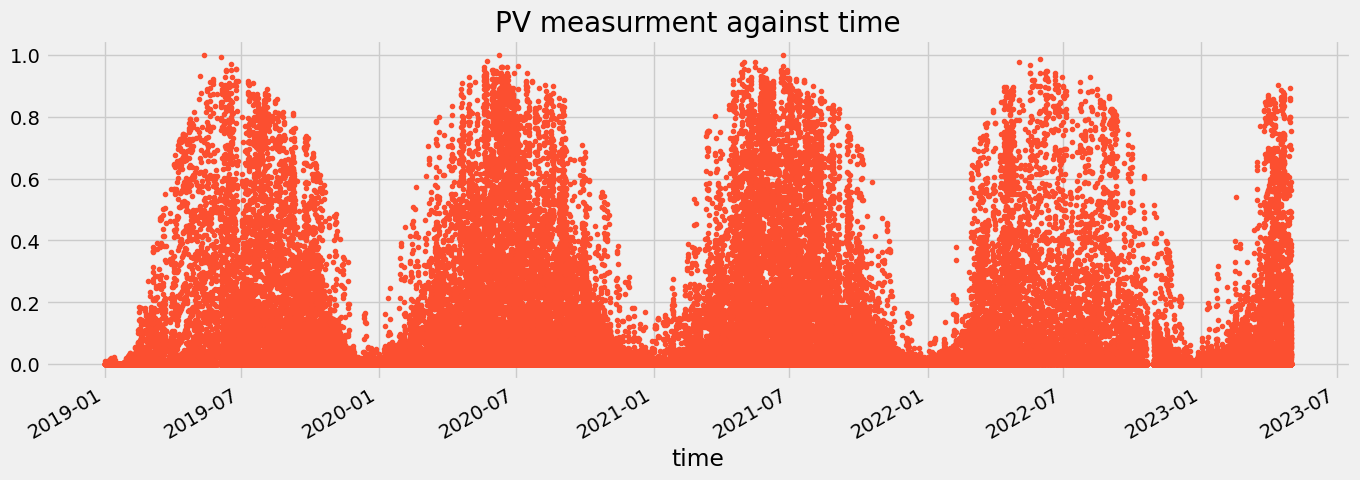

In [788]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [789]:
df.dtypes

location_A                                           int64
location_B                                           int64
location_C                                           int64
absolute_humidity_2m:gm3                           float32
air_density_2m:kgm3                                float32
clear_sky_energy_1h:J                              float32
clear_sky_rad:W                                    float32
dew_or_rime:idx                                    float32
dew_point_2m:K                                     float32
diffuse_rad:W                                      float32
diffuse_rad_1h:J                                   float32
direct_rad:W                                       float32
direct_rad_1h:J                                    float32
effective_cloud_cover:p                            float32
elevation:m                                        float32
fresh_snow_12h:cm                                  float32
fresh_snow_1h:cm                                   float

In [790]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').mean()

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1
    
    x_test = create_features(x_test)

    return x_test

In [791]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [792]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [793]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [794]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [795]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))
    print("len(X_test.columns) - len(check_train.columns) =", len(X_test.columns) - len(check_train.columns))
    print(X_test.columns)
    print(check_train.columns)

EQUAL


Check if test data has the right amount of rows.

In [796]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [797]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

parameters = {'colsample_bytree': [0.3],
               'learning_rate': [0.01],
                'max_depth': [6],
                'n_estimators': [1000]
}

X_train = df[FEATURES]
y_train = df[TARGET]

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb_model = grid_search.best_estimator_

# Get feature importances from this best model
feature_importances = best_xgb_model.feature_importances_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   2.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   3.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   3.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   4.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   4.5s


### Saving the Model!

In [798]:
import joblib

joblib.dump(grid_search, 'xgboost_model_feature_engineering_3.pkl')

['xgboost_model_feature_engineering_3.pkl']

### Get Feature imporances

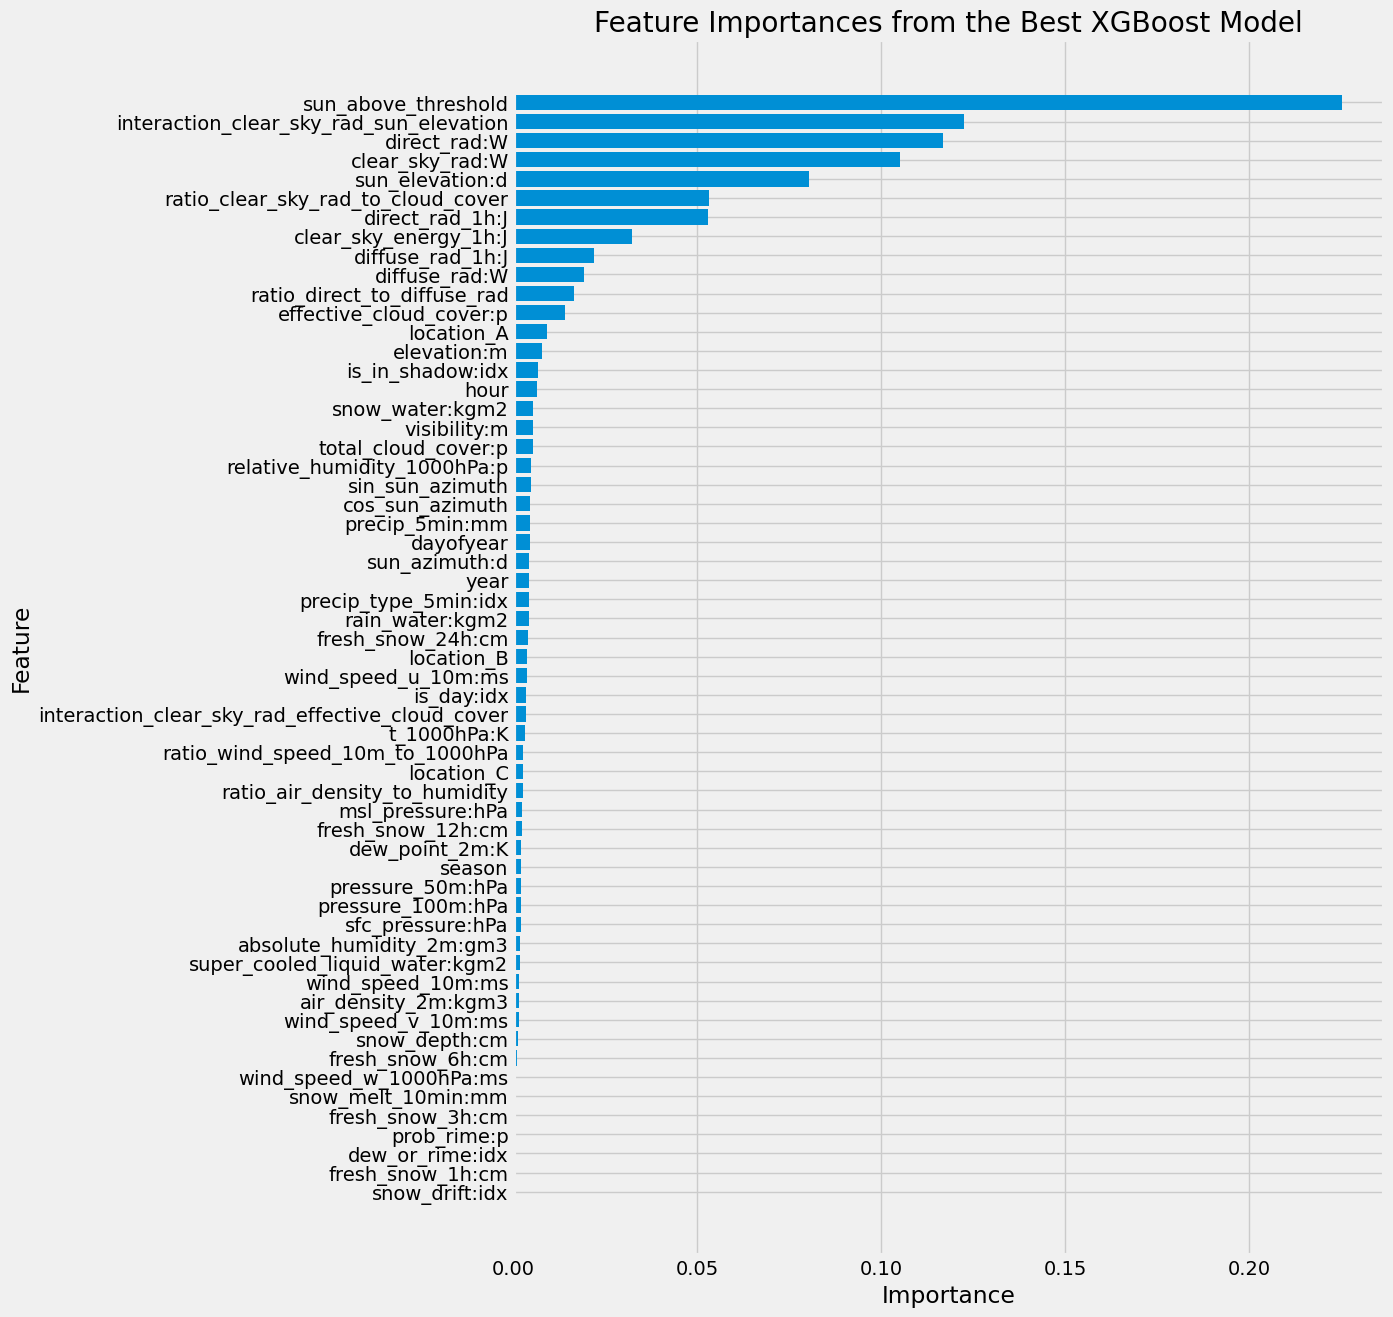

In [799]:
import matplotlib.pyplot as plt

# Sort importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(10, 15))
plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from the Best XGBoost Model')
plt.show()

In [800]:
best_score = grid_search.best_score_
print("Best score:", best_score)

#BEST = 0.8071057053353998

Best score: 0.8071057053353998


### Predict and make csv

0.79829437447415 -> All Deafualt Features

0.7980621793280911 -> Remove fresh_snow_1h:cm, fresh_snow_3h:cm, snow_drift:idx

0.799010140151314 -> Remove dew_point_2m:K

0.7989431505927528 -> Remove t_1000hPa:K	

0.7977502097357715 -> Remove total_cloud_cover:p

add back

0.7992045434377678 -> Remove 'diffuse_rad_1h:J', 'direct_rad_1h:J'

0.7993896634415224 -> adding fresh_snow_1h:cm, fresh_snow_3h:cm, snow_drift:idx

0.7997298826741328 -> adding t_1000hPa:K'

0.7999339030049968 -> Remove is_day:idx

0.7996934083218716 -> Remove 'snow_drift:idx'

add back

0.798814725848393 -> remove 'sfc_pressure:hPa'

add back

0.7988595656430141 -> remove 'fresh_snow_1h:cm', 'fresh_snow_3h:cm'
add back

0.8002694909273467 -> add sun_above_threshold

0.7989902296073009 -> add shadow_cos_sun_azimuth_interaction

remove

0.7988798639697329 clearsky int term
remove 

-> add cos_sun_azimuth

In [801]:
predictions = grid_search.predict(X_test)

In [802]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,0.004110
1,0.004012
2,0.003665
3,0.016114
4,0.071681


In [803]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [804]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [805]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [806]:
predictions.head(10)

,prediction
0,23.562469
1,23.003193
2,21.010492
3,92.389984
4,410.978821
5,869.047119
6,1708.156616
7,2608.667969
8,2947.772461
9,3069.521240


In [807]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [808]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [809]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

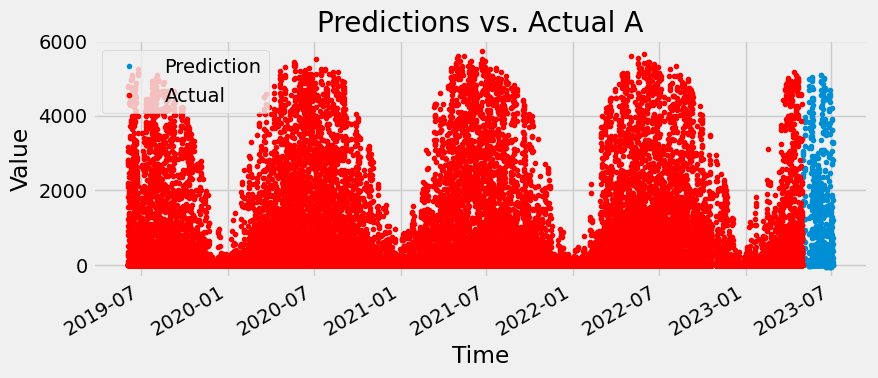

In [810]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


### Plotting B

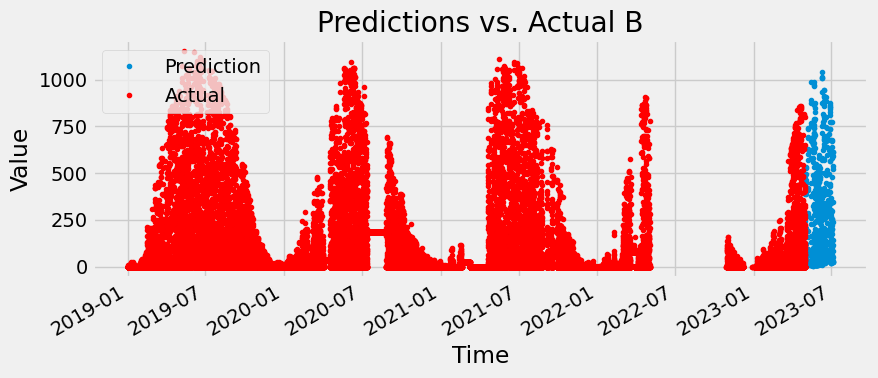

In [811]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

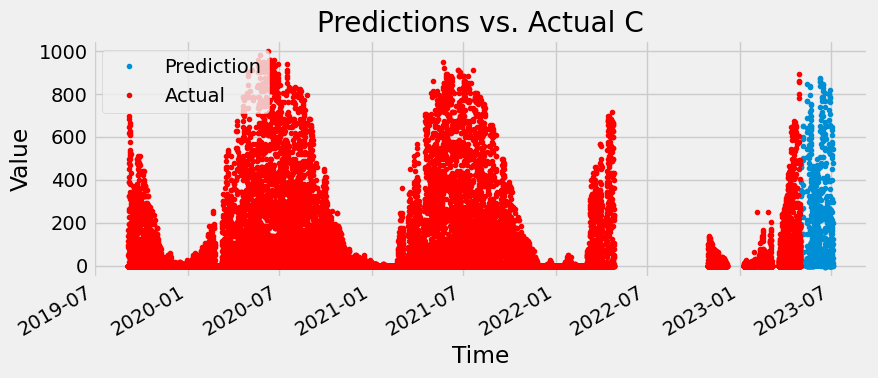

In [812]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

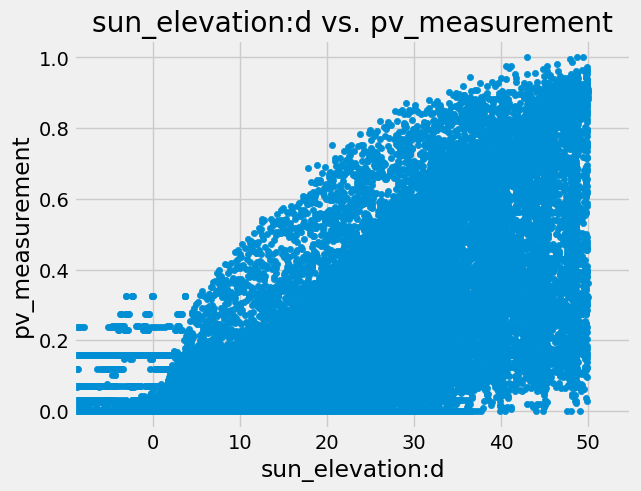

In [813]:
df.plot(x='sun_elevation:d', y='pv_measurement', kind='scatter', xlim =(-9,None))
plt.xlabel('sun_elevation:d')
plt.ylabel('pv_measurement')
plt.title('sun_elevation:d vs. pv_measurement')
plt.show()

In [814]:
# Compute the correlation matrix
corr_matrix = df.corr()

high_corr_pairs = []
for column in corr_matrix.columns:
    for index in corr_matrix.index:
        if abs(corr_matrix[column][index]) > 0.8 and column != index:
            if (index, column) not in high_corr_pairs and (column, index) not in high_corr_pairs:
                high_corr_pairs.append((column, index, corr_matrix[column][index]))

# Create DataFrame from results
corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Display the table
pd.set_option('display.max_rows', None)
corr_df

,Feature 1,Feature 2,Correlation
0,location_C,elevation:m,0.998550
1,absolute_humidity_2m:gm3,dew_point_2m:K,0.972714
2,absolute_humidity_2m:gm3,t_1000hPa:K,0.899181
3,air_density_2m:kgm3,dew_point_2m:K,-0.834155
4,air_density_2m:kgm3,t_1000hPa:K,-0.904251
5,clear_sky_energy_1h:J,clear_sky_rad:W,0.992406
6,clear_sky_energy_1h:J,diffuse_rad:W,0.912435
7,clear_sky_energy_1h:J,diffuse_rad_1h:J,0.922448
8,clear_sky_energy_1h:J,sun_elevation:d,0.829116
9,clear_sky_energy_1h:J,sun_above_threshold,0.848498
